# Introduction

### Implemented Recurrent Neural Network based Model owing to it's Time Series like data.
 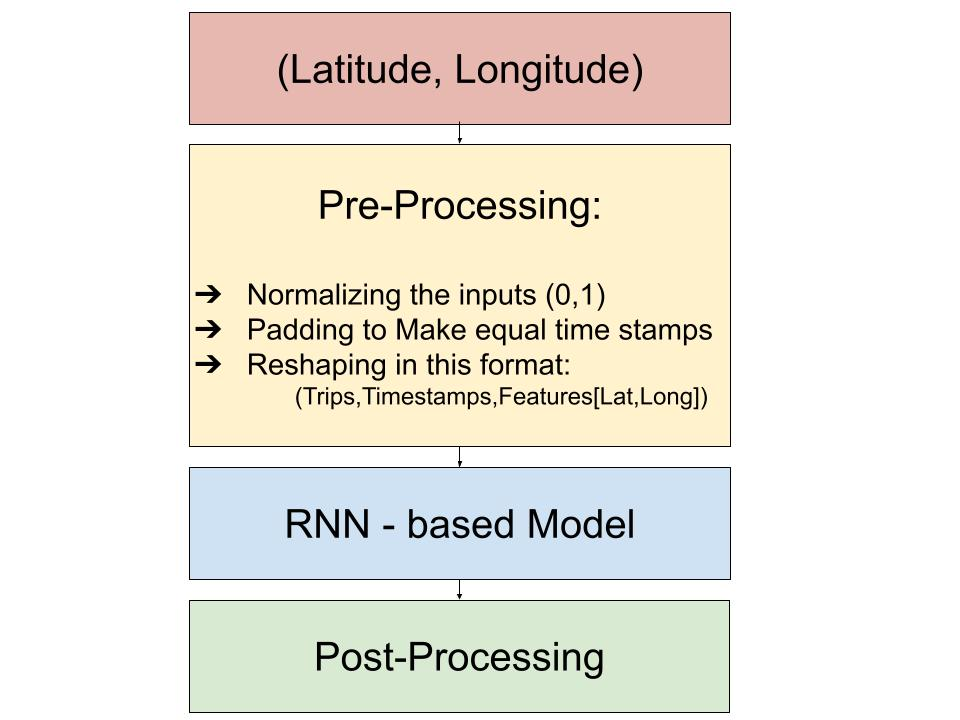



## This Notebook involves :
###  Data pre-processing
1. Normalizing the inputs for the model
2. Padding (For equal timestamps)
3. Reshaping in (Trips,Timestamps,[Lat,Long]) format

### Training
 - Building the Model using Keras
 - Training (Make sure to enable GPU)
 - Prediction
  
### Post-processing 
 - De-Normalizing
 - Submission
 
### Conclusion
 - When you train it you'll see that the model doesn't perform well due to overfitting.
 - There is very less data to train. Hence doesn't generalize well


#### Check if GPU is available or not

In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()

#### Imports

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import plotly.express as px

pd.set_option("max_columns", 500)

In [ ]:
!pip install nb_black > /dev/null
%load_ext lab_black

# Convert raw data to gps
Ref: [GSDC2 - baseline submission
](https://www.kaggle.com/code/saitodevel01/gsdc2-baseline-submission)

In [ ]:
import glob
from dataclasses import dataclass
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from scipy.interpolate import InterpolatedUnivariateSpline

INPUT_PATH = "../input/smartphone-decimeter-2022"

WGS84_SEMI_MAJOR_AXIS = 6378137.0
WGS84_SEMI_MINOR_AXIS = 6356752.314245
WGS84_SQUARED_FIRST_ECCENTRICITY = 6.69437999013e-3
WGS84_SQUARED_SECOND_ECCENTRICITY = 6.73949674226e-3

HAVERSINE_RADIUS = 6_371_000


@dataclass
class ECEF:
    x: np.array
    y: np.array
    z: np.array

    def to_numpy(self):
        return np.stack([self.x, self.y, self.z], axis=0)

    @staticmethod
    def from_numpy(pos):
        x, y, z = [np.squeeze(w) for w in np.split(pos, 3, axis=-1)]
        return ECEF(x=x, y=y, z=z)


@dataclass
class BLH:
    lat: np.array
    lng: np.array
    hgt: np.array


def ECEF_to_BLH(ecef):
    a = WGS84_SEMI_MAJOR_AXIS
    b = WGS84_SEMI_MINOR_AXIS
    e2 = WGS84_SQUARED_FIRST_ECCENTRICITY
    e2_ = WGS84_SQUARED_SECOND_ECCENTRICITY
    x = ecef.x
    y = ecef.y
    z = ecef.z
    r = np.sqrt(x**2 + y**2)
    t = np.arctan2(z * (a / b), r)
    B = np.arctan2(z + (e2_ * b) * np.sin(t) ** 3, r - (e2 * a) * np.cos(t) ** 3)
    L = np.arctan2(y, x)
    n = a / np.sqrt(1 - e2 * np.sin(B) ** 2)
    H = (r / np.cos(B)) - n
    return BLH(lat=B, lng=L, hgt=H)


def haversine_distance(blh_1, blh_2):
    dlat = blh_2.lat - blh_1.lat
    dlng = blh_2.lng - blh_1.lng
    a = (
        np.sin(dlat / 2) ** 2
        + np.cos(blh_1.lat) * np.cos(blh_2.lat) * np.sin(dlng / 2) ** 2
    )
    dist = 2 * HAVERSINE_RADIUS * np.arcsin(np.sqrt(a))
    return dist


def pandas_haversine_distance(df1, df2):
    blh1 = BLH(
        lat=np.deg2rad(df1["LatitudeDegrees"].to_numpy()),
        lng=np.deg2rad(df1["LongitudeDegrees"].to_numpy()),
        hgt=0,
    )
    blh2 = BLH(
        lat=np.deg2rad(df2["LatitudeDegrees"].to_numpy()),
        lng=np.deg2rad(df2["LongitudeDegrees"].to_numpy()),
        hgt=0,
    )
    return haversine_distance(blh1, blh2)


def ecef_to_lat_lng(tripID, gnss_df, UnixTimeMillis):
    ecef_columns = [
        "WlsPositionXEcefMeters",
        "WlsPositionYEcefMeters",
        "WlsPositionZEcefMeters",
    ]
    columns = ["utcTimeMillis"] + ecef_columns
    ecef_df = (
        gnss_df.drop_duplicates(subset="utcTimeMillis")[columns]
        .dropna()
        .reset_index(drop=True)
    )
    ecef = ECEF.from_numpy(ecef_df[ecef_columns].to_numpy())
    blh = ECEF_to_BLH(ecef)

    TIME = ecef_df["utcTimeMillis"].to_numpy()
    lat = InterpolatedUnivariateSpline(TIME, blh.lat, ext=3)(UnixTimeMillis)
    lng = InterpolatedUnivariateSpline(TIME, blh.lng, ext=3)(UnixTimeMillis)
    return pd.DataFrame(
        {
            "tripId": tripID,
            "UnixTimeMillis": UnixTimeMillis,
            "LatitudeDegrees": np.degrees(lat),
            "LongitudeDegrees": np.degrees(lng),
        }
    )


def calc_score(tripID, pred_df, gt_df):
    d = pandas_haversine_distance(pred_df, gt_df)
    score = np.mean([np.quantile(d, 0.50), np.quantile(d, 0.95)])
    return score

Ref: [📱 Smartphone Competition 2022 [Twitch Stream]](https://www.kaggle.com/code/robikscube/smartphone-competition-2022-twitch-stream)

In [ ]:
import glob

INPUT_PATH = "../input/smartphone-decimeter-2022"

sample_df = pd.read_csv(f"{INPUT_PATH}/sample_submission.csv")
pred_dfs = []
for dirname in tqdm(sorted(glob.glob(f"{INPUT_PATH}/test/*/*"))):
    drive, phone = dirname.split("/")[-2:]
    tripID = f"{drive}/{phone}"
    gnss_df = pd.read_csv(f"{dirname}/device_gnss.csv")
    UnixTimeMillis = sample_df[sample_df["tripId"] == tripID][
        "UnixTimeMillis"
    ].to_numpy()
    pred_dfs.append(ecef_to_lat_lng(tripID, gnss_df, UnixTimeMillis))
sub_df = pd.concat(pred_dfs)

baselines = []
gts = []
for dirname in tqdm(sorted(glob.glob(f"{INPUT_PATH}/train/*/*"))):
    drive, phone = dirname.split("/")[-2:]
    tripID = f"{drive}/{phone}"
    gnss_df = pd.read_csv(f"{dirname}/device_gnss.csv", low_memory=False)
    gt_df = pd.read_csv(f"{dirname}/ground_truth.csv", low_memory=False)
    baseline_df = ecef_to_lat_lng(tripID, gnss_df, gt_df["UnixTimeMillis"].to_numpy())
    baselines.append(baseline_df)
    gt_df["tripId"] = tripID
    gts.append(gt_df)
baselines = pd.concat(baselines)
gts = pd.concat(gts)

In [ ]:
ss = pd.read_csv("../input/smartphone-decimeter-2022/sample_submission.csv")

In [ ]:
baselines["group"] = "train_baseline"
sub_df["group"] = "submission_baseline"
gts["group"] = "train_ground_truth"
combined = pd.concat([baselines, sub_df]).reset_index(drop=True).copy()

In [ ]:
Lat = combined["LatitudeDegrees"].to_numpy()
Long = combined["LongitudeDegrees"].to_numpy()

In [ ]:
Lat_gt = gts["LatitudeDegrees"].to_numpy()
Long_gt = gts["LongitudeDegrees"].to_numpy()

# Normalization
Bringing Data to standard form so that is makes sense in the model

In [ ]:
from pandas import Series
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import sqrt

In [ ]:
# Latitude

series_Lat_train = Series(Lat.flatten())

series_Lat_gt = Series(Lat_gt.flatten())

values_train = series_Lat_train.values
values_train = values_train.reshape((len(values_train), 1))

print(values_train.shape)

values_gt = series_Lat_gt.values
values_gt = values_gt.reshape((len(values_gt), 1))

# train the normalization
scaler_lat = MinMaxScaler()
scaler_lat = scaler_lat.fit(values_train)

# normalize the dataset and print
standardized_lat_train = scaler_lat.transform(values_train)
# print(standardized_lat_train)
print(standardized_lat_train.shape)

standardized_lat_gt = scaler_lat.transform(values_gt)
print(standardized_lat_gt)
# print(standardized_lat_gt.shape)

# inverse transform and print
inversed_lat_train = scaler_lat.inverse_transform(standardized_lat_train)
# print(inversed_lat_train)
inversed_lat_gt = scaler_lat.inverse_transform(standardized_lat_gt)
# print(inversed_lat_gt)

In [ ]:
sub_df.shape

In [ ]:
standardized_lat_train = standardized_lat_train.reshape(361730)
standardized_lat_train_only = standardized_lat_train[0:295633]
baselines["standardized_lat"] = standardized_lat_train_only

standardized_lat_sub = standardized_lat_train[295633:]
ss["standardized_lat"] = standardized_lat_sub

gts["standardized_lat"] = standardized_lat_gt.reshape(295633)

In [ ]:
# Long

series_Long_train = Series(Long.flatten())
# print(series_Long_train)

series_Long_gt = Series(Long_gt.flatten())
# print(series_Long_gt)

values_train_long = series_Long_train.values
values_train_long = values_train_long.reshape((len(values_train_long), 1))

print(values_train_long.shape)

values_gt_long = series_Long_gt.values
values_gt_long = values_gt_long.reshape((len(values_gt_long), 1))

# train the normalization
# scaler_long = StandardScaler()
scaler_long = MinMaxScaler()
scaler_long = scaler_long.fit(values_train_long)

# normalize the dataset and print
standardized_long_train = scaler_long.transform(values_train_long)
# print(standardized_long_train)
print(standardized_long_train.shape)

standardized_long_gt = scaler_long.transform(values_gt_long)
print(standardized_long_gt)
# print(standardized_long_gt.shape)

# inverse transform and print
inversed_long_train = scaler_long.inverse_transform(standardized_long_train)
# print(inversed_lat_train)
inversed_long_gt = scaler_long.inverse_transform(standardized_long_gt)
# print(inversed_lat_gt)

In [ ]:
standardized_long_train = standardized_long_train.reshape(361730)
standardized_long_train_only = standardized_long_train[0:295633]
baselines["standardized_long"] = standardized_long_train_only

standardized_long_sub = standardized_long_train[295633:]
ss["standardized_long"] = standardized_long_sub

gts["standardized_long"] = standardized_long_gt.reshape(295633)

In [ ]:
gts.tail()

In [ ]:
baselines.tail()

In [ ]:
ss.tail()

# Reshaping the Data and Padding
(If you have any doubts related to this ask me in the comments.)

In [ ]:
max_length = np.amax(baselines["tripId"].value_counts())
desired_rows = max_length
desired_cols = 2
count = 0
for trip in baselines.tripId.unique():
    if count == 0:
        oneTrip = baselines.loc[
            (baselines["tripId"] == trip), ["standardized_lat", "standardized_long"]
        ]

        oneTrip = oneTrip.to_numpy()
        trainingPadded0 = np.pad(
            oneTrip,
            (
                (0, desired_rows - oneTrip.shape[0]),
                (0, desired_cols - oneTrip.shape[1]),
            ),
            "constant",
            constant_values=0,
        )
        count = 1
    elif count == 1:
        oneTrip = baselines.loc[
            (baselines["tripId"] == trip), ["standardized_lat", "standardized_long"]
        ]
        oneTrip = oneTrip.to_numpy()
        trainingPadded1 = np.pad(
            oneTrip,
            (
                (0, desired_rows - oneTrip.shape[0]),
                (0, desired_cols - oneTrip.shape[1]),
            ),
            "constant",
            constant_values=0,
        )
        trainingPadded = np.stack((trainingPadded0, trainingPadded1))
        count = 2
    else:
        oneTrip = baselines.loc[
            (baselines["tripId"] == trip), ["standardized_lat", "standardized_long"]
        ]
        oneTrip = oneTrip.to_numpy()
        oneTripPadded = np.pad(
            oneTrip,
            (
                (0, desired_rows - oneTrip.shape[0]),
                (0, desired_cols - oneTrip.shape[1]),
            ),
            "constant",
            constant_values=0,
        )

        # print(oneTrip.shape)
        # print(oneTripPadded.shape)
        trainingPadded = np.append(trainingPadded, [oneTripPadded], axis=0)

print(trainingPadded.shape)

In [ ]:
max_length = np.amax(gts["tripId"].value_counts())
desired_rows = max_length
desired_cols = 2
count = 0
for trip in gts.tripId.unique():
    if count == 0:
        oneTrip = gts.loc[
            (gts["tripId"] == trip), ["standardized_lat", "standardized_long"]
        ]

        oneTrip = oneTrip.to_numpy()
        gtsPadded0 = np.pad(
            oneTrip,
            (
                (0, desired_rows - oneTrip.shape[0]),
                (0, desired_cols - oneTrip.shape[1]),
            ),
            "constant",
            constant_values=0,
        )
        count = 1
    elif count == 1:
        oneTrip = gts.loc[
            (gts["tripId"] == trip), ["standardized_lat", "standardized_long"]
        ]
        oneTrip = oneTrip.to_numpy()
        gtsPadded1 = np.pad(
            oneTrip,
            (
                (0, desired_rows - oneTrip.shape[0]),
                (0, desired_cols - oneTrip.shape[1]),
            ),
            "constant",
            constant_values=0,
        )
        gtsPadded = np.stack((gtsPadded0, gtsPadded1))
        count = 2
    else:
        oneTrip = gts.loc[
            (gts["tripId"] == trip), ["standardized_lat", "standardized_long"]
        ]
        oneTrip = oneTrip.to_numpy()
        oneTripPadded = np.pad(
            oneTrip,
            (
                (0, desired_rows - oneTrip.shape[0]),
                (0, desired_cols - oneTrip.shape[1]),
            ),
            "constant",
            constant_values=0,
        )

        # print(oneTrip.shape)
        # print(oneTripPadded.shape)
        gtsPadded = np.append(gtsPadded, [oneTripPadded], axis=0)

print(gtsPadded.shape)

In [ ]:
max_length = np.amax(ss["tripId"].value_counts())
desired_rows = max_length
desired_cols = 2
count = 0
for trip in ss.tripId.unique():
    if count == 0:
        oneTrip = ss.loc[
            (ss["tripId"] == trip), ["standardized_lat", "standardized_long"]
        ]

        oneTrip = oneTrip.to_numpy()
        ssPadded0 = np.pad(
            oneTrip,
            (
                (0, desired_rows - oneTrip.shape[0]),
                (0, desired_cols - oneTrip.shape[1]),
            ),
            "constant",
            constant_values=0,
        )
        count = 1
    elif count == 1:
        oneTrip = ss.loc[
            (ss["tripId"] == trip), ["standardized_lat", "standardized_long"]
        ]
        oneTrip = oneTrip.to_numpy()
        ssPadded1 = np.pad(
            oneTrip,
            (
                (0, desired_rows - oneTrip.shape[0]),
                (0, desired_cols - oneTrip.shape[1]),
            ),
            "constant",
            constant_values=0,
        )
        ssPadded = np.stack((ssPadded0, ssPadded1))
        count = 2
    else:
        oneTrip = ss.loc[
            (ss["tripId"] == trip), ["standardized_lat", "standardized_long"]
        ]
        oneTrip = oneTrip.to_numpy()
        oneTripPadded = np.pad(
            oneTrip,
            (
                (0, desired_rows - oneTrip.shape[0]),
                (0, desired_cols - oneTrip.shape[1]),
            ),
            "constant",
            constant_values=0,
        )

        # print(oneTrip.shape)
        # print(oneTripPadded.shape)
        ssPadded = np.append(ssPadded, [oneTripPadded], axis=0)

print(ssPadded.shape)

# Training

In [ ]:
from keras.models import Sequential
from keras.models import Model

from keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.metrics import MeanSquaredError
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Masking, Bidirectional

from keras.models import Input

In [ ]:
number_of_features = 2
batch_size = 170
time_steps = 3362

input = Input(shape=(None, number_of_features))

masking = Masking(mask_value=0.0)(input)

Bidirectional_1 = Bidirectional(
    LSTM(number_of_features, return_sequences=True), merge_mode="sum"
)(masking)

Dropout_1 = Dropout(0.2)(Bidirectional_1)

out = Dense(number_of_features, activation="sigmoid")(Dropout_1)

model = Model(inputs=input, outputs=out)
model.compile(
    loss="MeanSquaredError",
    optimizer=Adam(lr=0.0003, decay=1e-3),
    metrics=["MeanSquaredError"],
)

model.summary()

In [ ]:
model.fit(
    trainingPadded,
    gtsPadded,
    epochs=600,
    batch_size=34,
    verbose=1,
    use_multiprocessing=True,
    shuffle=True,
    validation_split=0.1,
)

#### Prediction

In [ ]:
result = model.predict(trainingPadded)
print(result.shape)

In [ ]:
result_sub = model.predict(ssPadded)
print(ssPadded.shape)

In [ ]:
result_sub

# Scoring 
- inverse of values 
- reshaping for calc the mean error

In [ ]:
count = 0
predicted_lat = []
predicted_long = []
for trip in baselines.tripId.unique():
    timestamps = (baselines["tripId"] == trip).sum()
    for x in range(timestamps):
        predicted_lat.append(result[count][x][0])
        predicted_long.append(result[count][x][1])
    count = count + 1

In [ ]:
np_predicted = np.array(predicted_lat)
series_np_predicted = Series(np_predicted.flatten())
values_np_predicted = series_np_predicted.values
values_np_predicted = values_np_predicted.reshape((len(values_np_predicted), 1))
inversed_np_predicted = scaler_lat.inverse_transform(values_np_predicted)
baselines["predicted_lat"] = inversed_np_predicted

np_predicted = np.array(predicted_long)
series_np_predicted = Series(np_predicted.flatten())
values_np_predicted = series_np_predicted.values
values_np_predicted = values_np_predicted.reshape((len(values_np_predicted), 1))
inversed_np_predicted = scaler_long.inverse_transform(values_np_predicted)
baselines["predicted_long"] = inversed_np_predicted

In [ ]:
predicted_baseline = baselines[["tripId", "predicted_lat", "predicted_long"]].copy()
predicted_baseline.rename(columns={"predicted_lat": "LatitudeDegrees"}, inplace=True)
predicted_baseline.rename(columns={"predicted_long": "LongitudeDegrees"}, inplace=True)

scores = []
for tripID in predicted_baseline["tripId"].unique():
    score = calc_score(tripID, predicted_baseline, gts)
    scores.append(score)

mean_score = np.mean(scores)
print(f"mean_score = {mean_score:.3f}")

# Submission

In [ ]:
count = 0
predicted_lat = []
predicted_long = []
for trip in ss.tripId.unique():
    timestamps = (ss["tripId"] == trip).sum()
    for x in range(timestamps):
        predicted_lat.append(result_sub[count][x][0])
        predicted_long.append(result_sub[count][x][1])
    count = count + 1

In [ ]:
np_predicted = np.array(predicted_lat)
series_np_predicted = Series(np_predicted.flatten())
values_np_predicted = series_np_predicted.values
values_np_predicted = values_np_predicted.reshape((len(values_np_predicted), 1))
inversed_np_predicted = scaler_lat.inverse_transform(values_np_predicted)
ss["LatitudeDegrees"] = inversed_np_predicted

np_predicted = np.array(predicted_long)
series_np_predicted = Series(np_predicted.flatten())
values_np_predicted = series_np_predicted.values
values_np_predicted = values_np_predicted.reshape((len(values_np_predicted), 1))
inversed_np_predicted = scaler_long.inverse_transform(values_np_predicted)
ss["LongitudeDegrees"] = inversed_np_predicted

In [ ]:
ss.head()

In [ ]:
ss.drop(["standardized_lat", "standardized_long"], axis=1, inplace=True)

In [ ]:
ss.head() #updated with our predictions

In [ ]:
ss.reset_index(drop=True)[ss.columns].to_csv("submission.csv", index=False)